Tarea MLP - Inteligencia Computacional
 Aproximacion funcional

* _Maria Alejandra Bonilla Diaz - 20251595002_ 
* _Alvaro Alejandro Zarabanda Gutierrez – 20251595006_
* _Youssef Alejandro Ortiz Vargas – 20251595004_

Implementar un MLP con arquitectura 3-10-1 usando el algoritmo de backpropagation (regla delta generalizada) para aproximar una función multivariable.

***Especificaciones:***

- **Arquitectura:** 3 entradas → 10 neuronas ocultas → 1 salida

- **Función de activación:** Sigmoide

- **Tasa de aprendizaje ($\eta$):** 0.1

- **Precisión ($\epsilon$):** 10⁻⁶

- **Datos de entrenamiento:** 200 muestras 

- **Datos de prueba:** 20 muestras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
# Funciones de activación
def funcion_sigmoide(entrada):
    """Función logística sigmoide: f(x) = 1 / (1 + exp(-x))"""
    return 1.0 / (1.0 + np.exp(-entrada))

def derivada_sigmoide(salida_activada):
    """Derivada de la función sigmoide: f'(x) = f(x) * (1 - f(x))"""
    return salida_activada * (1.0 - salida_activada)

# Funciones de evaluación y métricas
def calcular_error_cuadratico_medio(valores_reales, valores_predichos):
    """Calcula el Error Cuadrático Medio (MSE)"""
    return np.mean((valores_reales - valores_predichos)**2)

def calcular_error_relativo_porcentual(valores_reales, valores_predichos):
    """Calcula el error relativo medio (%) y su varianza"""
    epsilon = 1e-12
    errores_relativos = np.abs((valores_reales - valores_predichos) / (np.abs(valores_reales) + epsilon))
    return 100.0 * np.mean(errores_relativos), 100.0 * np.var(errores_relativos)

def calcular_coeficiente_determinacion(valores_reales, valores_predichos):
    """Calcula el coeficiente de determinación R²"""
    valores_reales = valores_reales.reshape(-1, 1)
    valores_predichos = valores_predichos.reshape(-1, 1)
    suma_residuos = np.sum((valores_reales - valores_predichos)**2)
    suma_total = np.sum((valores_reales - np.mean(valores_reales))**2) + 1e-12
    return 1.0 - (suma_residuos / suma_total)

# Normalizador de datos
class NormalizadorMinMax:
    """Normaliza datos al rango [0, 1] usando transformación MinMax"""
    
    def ajustar(self, datos):
        self.valor_minimo = datos.min(axis=0)
        self.valor_maximo = datos.max(axis=0)
        self.rango = np.where(self.valor_maximo - self.valor_minimo == 0, 
                              1.0, self.valor_maximo - self.valor_minimo)
        return self
    
    def transformar(self, datos):
        return (datos - self.valor_minimo) / self.rango
    
    def ajustar_y_transformar(self, datos):
        return self.ajustar(datos).transformar(datos)

print("✓ Funciones auxiliares y normalizador implementados correctamente")

✓ Funciones auxiliares y normalizador implementados correctamente


**Funciones implementadas:**

1. **Función de Activación Sigmoide:**
   - Fórmula: $\sigma(x) = \frac{1}{1 + e^{-x}}$
   - Rango de salida: [0, 1]
   - Uso: Activación de neuronas en capas oculta y de salida

2. **Derivada de la Sigmoide:**
   - Fórmula: $\sigma'(x) = \sigma(x) \cdot (1 - \sigma(x))$
   - Uso: Cálculo de gradientes durante backpropagation

3. **Error Cuadrático Medio (MSE):**
   - Fórmula: $MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$
   - Uso: Métrica de entrenamiento

4. **Error Relativo Porcentual:**
   - Calcula el error relativo medio y su varianza en porcentaje
   - Uso: Evaluación de generalización en conjunto de prueba

5. **Coeficiente de Determinación R²:**
   - Mide bondad de ajuste del modelo
   - Rango: [0, 1] donde 1 es ajuste perfecto

6. **Clase NormalizadorMinMax:**
   - Escala datos al rango [0, 1]
   - Métodos: `ajustar()`, `transformar()`, `ajustar_y_transformar()`
   - Uso: Normalización de características de entrada


Clase MLP con Backpropagation

Implementación del algoritmo de **backpropagation (regla delta generalizada)** para entrenar una red neuronal multicapa.

In [ ]:
class RedNeuronalMLP:
    """
    Perceptrón Multicapa (MLP) para regresión con activación sigmoide.
    
    Parámetros:
    -----------
    num_entradas : int
        Dimensión de las características de entrada
    num_ocultas : int
        Cantidad de neuronas en la capa oculta
    num_salidas : int
        Dimensión de la salida
    tasa_aprendizaje : float
        Factor de actualización de pesos (learning rate)
    tolerancia : float
        Umbral de convergencia para detener el entrenamiento
    epocas_maximas : int
        Límite de iteraciones de entrenamiento
    semilla : int, opcional
        Valor para reproducibilidad aleatoria
    """
    
    def __init__(self, num_entradas, num_ocultas, num_salidas, 
                 tasa_aprendizaje=0.1, tolerancia=1e-6, epocas_maximas=20000, semilla=None):
        self.num_entradas = num_entradas
        self.num_ocultas = num_ocultas
        self.num_salidas = num_salidas
        self.tasa_aprendizaje = tasa_aprendizaje
        self.tolerancia = tolerancia
        self.epocas_maximas = epocas_maximas
        self.generador_aleatorio = np.random.default_rng(semilla)
        
        limite_capa_oculta = np.sqrt(6.0 / (num_entradas + num_ocultas))
        limite_capa_salida = np.sqrt(6.0 / (num_ocultas + num_salidas))
        
        self.pesos_entrada_oculta = self.generador_aleatorio.uniform(
            -limite_capa_oculta, limite_capa_oculta, size=(num_entradas, num_ocultas))
        self.sesgo_oculta = np.zeros((1, num_ocultas))
        
        self.pesos_oculta_salida = self.generador_aleatorio.uniform(
            -limite_capa_salida, limite_capa_salida, size=(num_ocultas, num_salidas))
        self.sesgo_salida = np.zeros((1, num_salidas))
        
        self.historial_error = []
    
    def propagacion_adelante(self, X):
        """Fase de propagación hacia adelante (forward propagation)"""
        self.combinacion_lineal_oculta = X @ self.pesos_entrada_oculta + self.sesgo_oculta
        self.activacion_oculta = funcion_sigmoide(self.combinacion_lineal_oculta)
        
        self.combinacion_lineal_salida = self.activacion_oculta @ self.pesos_oculta_salida + self.sesgo_salida
        self.activacion_salida = funcion_sigmoide(self.combinacion_lineal_salida)
        
        return self.activacion_salida
    
    def propagacion_atras(self, X, valores_objetivo, predicciones):
        """Fase de retropropagación (backpropagation) - Regla delta generalizada"""
        num_muestras = X.shape[0]
        
        # Cálculo de gradientes para la capa de salida
        gradiente_error_salida = 2.0 * (predicciones - valores_objetivo) / num_muestras
        gradiente_activacion_salida = gradiente_error_salida * derivada_sigmoide(predicciones)
        gradiente_pesos_salida = self.activacion_oculta.T @ gradiente_activacion_salida
        gradiente_sesgo_salida = np.sum(gradiente_activacion_salida, axis=0, keepdims=True)
        
        # Cálculo de gradientes para la capa oculta
        gradiente_error_oculta = gradiente_activacion_salida @ self.pesos_oculta_salida.T
        gradiente_activacion_oculta = gradiente_error_oculta * derivada_sigmoide(self.activacion_oculta)
        gradiente_pesos_oculta = X.T @ gradiente_activacion_oculta
        gradiente_sesgo_oculta = np.sum(gradiente_activacion_oculta, axis=0, keepdims=True)
        
        # Actualización de parámetros mediante descenso del gradiente
        self.pesos_oculta_salida -= self.tasa_aprendizaje * gradiente_pesos_salida
        self.sesgo_salida -= self.tasa_aprendizaje * gradiente_sesgo_salida
        self.pesos_entrada_oculta -= self.tasa_aprendizaje * gradiente_pesos_oculta
        self.sesgo_oculta -= self.tasa_aprendizaje * gradiente_sesgo_oculta
    
    def entrenar(self, X, y):
        """Proceso de entrenamiento completo de la red neuronal"""
        error_previo = float('inf')
        
        for iteracion in range(self.epocas_maximas):
            # Propagación hacia adelante
            predicciones = self.propagacion_adelante(X)
            error_actual = calcular_error_cuadratico_medio(y, predicciones)
            self.historial_error.append(error_actual)
            
            # Propagación hacia atrás
            self.propagacion_atras(X, y, predicciones)
            
            # Verificar convergencia
            if abs(error_previo - error_actual) < self.tolerancia:
                break
            
            error_previo = error_actual
        
        self.epocas_entrenadas = len(self.historial_error)
        return self
    
    def predecir(self, X):
        """Genera predicciones para nuevos datos"""
        return self.propagacion_adelante(X)

**Arquitectura de la Red:**

- **Capa de entrada:** 3 neuronas ($x_1$, $x_2$, $x_3$)

- **Capa oculta:** 10 neuronas con activación sigmoide

- **Capa de salida:** 1 neurona con activación sigmoide

**Parámetros del Constructor:**

- `num_entradas`: Dimensión de entrada (3)

- `num_ocultas`: Neuronas en capa oculta (10)

- `num_salidas`: Dimensión de salida (1)

- `tasa_aprendizaje`: Factor η = 0.1

- `tolerancia`: Criterio de parada ε = 10⁻⁶

- `epocas_maximas`: Límite de iteraciones = 20,000

- `semilla`: Para reproducibilidad de resultados

**Inicialización de Pesos:**

- Método: Xavier/Glorot initialization

- Capa oculta: $limite = \sqrt{\frac{6}{n_{entrada} + n_{oculta}}}$

- Capa salida: $limite = \sqrt{\frac{6}{n_{oculta} + n_{salida}}}$

- Pesos distribuidos uniformemente en [-limite, +limite]

- Sesgos inicializados en cero

**Métodos Implementados:**

1. **`propagacion_adelante(X)`:**

   - Calcula salida de la red mediante forward propagation

   - Capa oculta: $h = \sigma(X \cdot W_1 + b_1)$
   
   - Capa salida: $\hat{y} = \sigma(h \cdot W_2 + b_2)$

2. **`propagacion_atras(X, y, ŷ)`:**

   - Implementa regla delta generalizada (backpropagation)

   - Calcula gradientes de la función de pérdida

   - Actualiza pesos mediante descenso del gradiente

   - Fórmula actualización: $W := W - \eta \cdot \nabla L$

3. **`entrenar(X, y)`:**

   - Ejecuta el proceso completo de entrenamiento

   - Alterna entre propagación adelante y atrás

   - Criterio de parada: $|MSE_{t} - MSE_{t-1}| < \epsilon$

   - Retorna modelo entrenado con historial de errores

4. **`predecir(X)`:**

   - Genera predicciones para datos nuevos

   - Ejecuta solo propagación adelante (sin backpropagation)


Datos de entrenamiento y prueba

**Appendix C:** 200 muestras de entrenamiento  

**Table 5.3:** 20 muestras de prueba

In [ ]:
# APPENDIX C: Conjunto de datos para entrenamiento (200 muestras)
DATOS_ENTRENAMIENTO_CONJUNTO = [
 (0.8799,0.7998,0.3972,0.8399),(0.5700,0.5111,0.2418,0.6258),(0.6796,0.4117,0.3370,0.6622),
 (0.3567,0.2967,0.6037,0.5969),(0.3866,0.8390,0.0232,0.5316),(0.0271,0.7788,0.7445,0.6335),
 (0.8174,0.8422,0.3229,0.8068),(0.6027,0.1468,0.3759,0.5342),(0.1203,0.3260,0.5419,0.4768),
 (0.1325,0.2082,0.4934,0.4105),(0.6950,1.0000,0.4321,0.8404),(0.0036,0.1940,0.3274,0.2697),
 (0.2650,0.0161,0.5947,0.4125),(0.5849,0.6019,0.4376,0.7464),(0.0108,0.3538,0.1810,0.2800),
 (0.9008,0.7264,0.9184,0.9602),(0.0023,0.9659,0.3182,0.4986),(0.1366,0.6357,0.6967,0.6459),
 (0.8621,0.7353,0.2742,0.7718),(0.0682,0.9624,0.4211,0.5764),(0.6112,0.6014,0.5254,0.7868),
 (0.0030,0.7585,0.8928,0.6388),(0.7644,0.5964,0.0407,0.6055),(0.6441,0.2097,0.5847,0.6545),
 (0.0803,0.3799,0.6020,0.4991),(0.1908,0.8046,0.5402,0.6665),(0.6937,0.3967,0.6055,0.7595),
 (0.2591,0.0582,0.3978,0.3604),(0.4241,0.1850,0.9066,0.6298),(0.3332,0.9303,0.2475,0.6287),
 (0.3625,0.1592,0.9981,0.5948),(0.9259,0.0960,0.1645,0.4716),(0.8606,0.6779,0.0033,0.6242),
 (0.0838,0.5472,0.3758,0.4835),(0.0303,0.9191,0.7233,0.6491),(0.9293,0.8319,0.9664,0.9840),
 (0.7268,0.1440,0.9753,0.7096),(0.2888,0.6593,0.4078,0.6328),(0.5515,0.1364,0.2894,0.4745),
 (0.7683,0.0067,0.5546,0.5708),(0.6462,0.6761,0.8340,0.8933),(0.3694,0.2212,0.1233,0.3658),
 (0.2706,0.3222,0.9996,0.6310),(0.6282,0.1404,0.8474,0.6733),(0.5861,0.6693,0.3818,0.7433),
 (0.6057,0.9901,0.5141,0.8466),(0.5915,0.5588,0.3055,0.6787),(0.8359,0.4145,0.5016,0.7597),
 (0.5497,0.6319,0.8382,0.8521),(0.7072,0.1721,0.3812,0.5772),(0.1185,0.5084,0.8376,0.6211),
 (0.6365,0.5562,0.4965,0.7693),(0.4145,0.5797,0.8599,0.7878),(0.2575,0.5358,0.4028,0.5777),
 (0.2026,0.3300,0.3054,0.4261),(0.3385,0.0476,0.5941,0.4625),(0.4094,0.1726,0.7803,0.6015),
 (0.1261,0.6181,0.4927,0.5739),(0.1224,0.4662,0.2146,0.4007),(0.6793,0.6774,1.0000,0.9141),
 (0.8176,0.0358,0.2506,0.4707),(0.6937,0.6685,0.5075,0.8220),(0.2404,0.5411,0.8754,0.6980),
 (0.6553,0.2609,0.1188,0.4851),(0.8886,0.0288,0.2604,0.4802),(0.3974,0.5275,0.6457,0.7215),
 (0.2108,0.4910,0.5432,0.5913),(0.8675,0.5571,0.1849,0.6805),(0.5693,0.0242,0.9293,0.6033),
 (0.8439,0.4631,0.6345,0.8226),(0.3644,0.2948,0.3937,0.5240),(0.2014,0.6326,0.9782,0.7143),
 (0.4039,0.0645,0.4629,0.4547),(0.7137,0.0670,0.2359,0.4602),(0.4277,0.9555,0.0000,0.5477),
 (0.0259,0.7634,0.2889,0.4738),(0.1871,0.7682,0.9697,0.7397),(0.3216,0.5420,0.0677,0.4526),
 (0.2524,0.7688,0.9523,0.7711),(0.3621,0.5295,0.2521,0.5571),(0.2942,0.1625,0.2745,0.3759),
 (0.8180,0.0023,0.1439,0.4018),(0.8429,0.1704,0.5251,0.6563),(0.9612,0.6898,0.6630,0.9128),
 (0.1009,0.4190,0.0826,0.3055),(0.7071,0.7704,0.8328,0.9298),(0.3371,0.7819,0.0959,0.5377),
 (0.1555,0.5599,0.9221,0.6663),(0.7318,0.1877,0.3311,0.5689),(0.1665,0.7449,0.0997,0.4508),
 (0.8762,0.2498,0.9167,0.7829),(0.9885,0.6229,0.2085,0.7200),(0.0461,0.7745,0.5632,0.5949),
 (0.3209,0.6229,0.5233,0.6810),(0.9189,0.5930,0.7288,0.8989),(0.0382,0.5515,0.8818,0.5999),
 (0.3726,0.9988,0.3814,0.7086),(0.4211,0.2668,0.3307,0.5080),(0.2378,0.0817,0.3574,0.3452),
 (0.9893,0.7637,0.2526,0.7755),(0.8203,0.0682,0.4260,0.5643),(0.6226,0.2146,0.1021,0.4452),
 (0.4589,0.3147,0.2236,0.4962),(0.3471,0.8889,0.1564,0.5875),(0.5762,0.8292,0.4116,0.7853),
 (0.9053,0.6245,0.5264,0.8506),(0.2860,0.0793,0.0549,0.2224),(0.9567,0.3034,0.4425,0.6993),
 (0.5170,0.9266,0.1565,0.6594),(0.8149,0.0396,0.6227,0.6165),(0.3710,0.3554,0.5633,0.6171),
 (0.8702,0.3185,0.2762,0.6287),(0.1016,0.6382,0.3173,0.4957),(0.3890,0.2369,0.0083,0.3235),
 (0.2702,0.8617,0.1218,0.5319),(0.7473,0.6507,0.5582,0.8464),(0.9108,0.2139,0.4641,0.6625),
 (0.4343,0.6028,0.1344,0.5546),(0.6847,0.4062,0.9318,0.8204),(0.8657,0.9448,0.9900,0.9904),
 (0.4011,0.4138,0.8715,0.7222),(0.5949,0.2600,0.0810,0.4480),(0.1845,0.7906,0.9725,0.7425),
 (0.3438,0.6725,0.9821,0.7926),(0.8398,0.1360,0.9119,0.7222),(0.2245,0.0971,0.6136,0.4402),
 (0.3742,0.9668,0.8194,0.8371),(0.9572,0.9836,0.3793,0.8556),(0.7496,0.0410,0.1360,0.4059),
 (0.9123,0.3510,0.0682,0.5455),(0.6954,0.5500,0.6801,0.8388),(0.5252,0.6529,0.5729,0.7893),
 (0.3156,0.3851,0.5983,0.6161),(0.1460,0.1637,0.0249,0.1813),(0.7780,0.4491,0.4614,0.7498),
 (0.5959,0.8647,0.8601,0.9176),(0.2204,0.1785,0.4607,0.4276),(0.7355,0.8264,0.7015,0.9214),
 (0.9931,0.6727,0.3139,0.7829),(0.9123,0.0000,0.1106,0.3944),(0.2858,0.9688,0.2262,0.5988),
 (0.7931,0.8993,0.9028,0.9728),(0.7841,0.0778,0.9012,0.6832),(0.1380,0.5881,0.2367,0.4622),
 (0.6345,0.5165,0.7139,0.8191),(0.2453,0.5888,0.1559,0.4765),(0.1174,0.5436,0.3657,0.4953),
 (0.3667,0.3228,0.6952,0.6376),(0.9532,0.6949,0.4451,0.8426),(0.7954,0.8346,0.0449,0.6676),
 (0.1427,0.0480,0.6267,0.3780),(0.1516,0.9824,0.0827,0.4627),(0.4868,0.6223,0.7462,0.8116),
 (0.3408,0.5115,0.0783,0.4559),(0.8146,0.6378,0.5837,0.8628),(0.2820,0.5409,0.7256,0.6939),
 (0.5716,0.2958,0.5477,0.6619),(0.9323,0.0229,0.4797,0.5731),(0.2907,0.7245,0.5165,0.6911),
 (0.0068,0.0545,0.0861,0.0851),(0.2636,0.9885,0.2175,0.5847),(0.0350,0.3653,0.7801,0.5117),
 (0.9670,0.3031,0.7127,0.7836),(0.0000,0.7763,0.8735,0.6388),(0.4395,0.0501,0.9761,0.5712),
 (0.9359,0.0366,0.9514,0.6826),(0.0173,0.9548,0.4289,0.5527),(0.6112,0.9070,0.6286,0.8803),
 (0.2010,0.9573,0.6791,0.7283),(0.8914,0.9144,0.2641,0.7966),(0.0061,0.0802,0.8621,0.3711),
 (0.2212,0.4664,0.3821,0.5260),(0.2401,0.6964,0.0751,0.4637),(0.7881,0.9833,0.3038,0.8049),
 (0.2435,0.0794,0.5551,0.4223),(0.2752,0.8414,0.2797,0.6079),(0.7616,0.4698,0.5337,0.7809),
 (0.3395,0.0022,0.0087,0.1836),(0.7849,0.9981,0.4449,0.8641),(0.8312,0.0961,0.2129,0.4857),
 (0.9763,0.1102,0.6227,0.6667),(0.8597,0.3284,0.6932,0.7829),(0.9295,0.3275,0.7536,0.8016),
 (0.2435,0.2163,0.7625,0.5449),(0.9281,0.8356,0.5285,0.8991),(0.8313,0.7566,0.6192,0.9047),
 (0.1712,0.0545,0.5033,0.3561),(0.0609,0.1702,0.4306,0.3310),(0.5899,0.9408,0.0369,0.6245),
 (0.7858,0.5115,0.0916,0.6066),(1.0000,0.1653,0.7103,0.7172),(0.2007,0.1163,0.3431,0.3385),
 (0.2306,0.0330,0.0293,0.1590),(0.8477,0.6378,0.4623,0.8254),(0.9677,0.7895,0.9467,0.9782),
 (0.0339,0.4669,0.1526,0.3250),(0.0080,0.8988,0.4201,0.5404),(0.9955,0.8897,0.6175,0.9360),
 (0.7408,0.5351,0.2732,0.6949),(0.6843,0.3737,0.1562,0.5625)
]

# TABLE 5.3: Conjunto de datos para validación (20 muestras)
DATOS_PRUEBA_CONJUNTO = [
 (0.0611,0.2860,0.7464,0.4831),(0.5102,0.7464,0.0860,0.5965),(0.0004,0.6916,0.5006,0.5318),
 (0.9430,0.4476,0.2648,0.6843),(0.1399,0.1610,0.2477,0.2872),(0.6423,0.3229,0.8567,0.7663),
 (0.6492,0.0007,0.6422,0.5666),(0.1818,0.5078,0.9046,0.6601),(0.7382,0.2647,0.1916,0.5427),
 (0.3879,0.1307,0.8656,0.5836),(0.1903,0.6523,0.7820,0.6950),(0.8401,0.4490,0.2719,0.6790),
 (0.0629,0.3264,0.2476,0.2956),(0.7088,0.9342,0.2763,0.7742),(0.1283,0.1882,0.7253,0.4662),
 (0.8882,0.3677,0.8931,0.8093),(0.2225,0.9182,0.7820,0.7581),(0.1957,0.8423,0.3085,0.5826),
 (0.9991,0.5914,0.3933,0.7938),(0.2299,0.1524,0.7353,0.5012)
]

# Construcción de estructuras de datos
datos_entrenamiento = pd.DataFrame(DATOS_ENTRENAMIENTO_CONJUNTO, columns=['x1', 'x2', 'x3', 'd']).astype(float)
datos_prueba = pd.DataFrame(DATOS_PRUEBA_CONJUNTO, columns=['x1', 'x2', 'x3', 'd']).astype(float)

**Datos Cargados:**

**1. Conjunto de Entrenamiento (APPENDIX C):**

- **Total de muestras:** 200

- **Características:** ($x_1$, $x_2$, $x_3$) (variables independientes)

- **Variable objetivo:** d (variable dependiente)

- **Formato:** DataFrame de Pandas con 4 columnas

- **Rango de valores:** [0, 1] para todas las variables

**2. Conjunto de Prueba (TABLE 5.3):**

- **Total de muestras:** 20

- **Características:** ($x_1$, $x_2$, $x_3$)

- **Variable objetivo:** d

- **Uso:** Validación final de las configuraciones entrenadas

**Ejemplo de Datos (Primeras 5 muestras de entrenamiento):**

| Muestra | $x_1$     | $x_2$     | $x_3$     | d      |
|---------|--------|--------|--------|--------|
| 1       | 0.8799 | 0.7998 | 0.3972 | 0.8399 |
| 2       | 0.5700 | 0.5111 | 0.2418 | 0.6258 |
| 3       | 0.6796 | 0.4117 | 0.3370 | 0.6622 |
| 4       | 0.3567 | 0.2967 | 0.6037 | 0.5969 |
| 5       | 0.3866 | 0.8390 | 0.0232 | 0.5316 |


Preprocesamiento de datos

Escalado de las entradas (x₁, x₂, x₃) al rango [0,1] usando MinMax scaling.

In [ ]:
# Separación de características y variable objetivo
caracteristicas_entrenamiento_raw = datos_entrenamiento[['x1', 'x2', 'x3']].values
objetivos_entrenamiento = datos_entrenamiento[['d']].values

caracteristicas_prueba_raw = datos_prueba[['x1', 'x2', 'x3']].values
objetivos_prueba = datos_prueba[['d']].values

# Normalización exclusiva de las características de entrada (la salida 'd' permanece sin escalar)
normalizador = NormalizadorMinMax()
caracteristicas_entrenamiento = normalizador.ajustar_y_transformar(caracteristicas_entrenamiento_raw)
caracteristicas_prueba = normalizador.transformar(caracteristicas_prueba_raw)

**Proceso de Normalización:**

1. **Separación de variables:**

   - Características (X): columnas $x_1$, $x_2$, $x_3$

   - Objetivo (y): columna d

2. **Normalización MinMax aplicada SOLO a características:**

   - Fórmula: $X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$

   - Rango de salida: [0, 1]

   - **Importante:** La variable objetivo (d) NO se normaliza según especificaciones

3. **Transformación coherente:**

   - El normalizador se ajusta con datos de entrenamiento

   - La misma transformación se aplica a datos de prueba

   - Esto evita data leakage y garantiza consistencia

**Dimensiones Verificadas:**

| Conjunto       | Características | Objetivos |
|----------------|----------------|-----------|
| Entrenamiento  | (200, 3)       | (200, 1)  |
| Prueba         | (20, 3)        | (20, 1)   |

**Rangos de Valores:**

- **Características normalizadas:** [0.0000, 1.0000] ✓

- **Objetivos sin normalizar:** [0.0851, 0.9904] ✓

**Justificación:** La normalización de entradas acelera la convergencia del algoritmo de backpropagation y mejora la estabilidad numérica durante el entrenamiento.


# Entrenamiento - Item 1 & 2

**Item 1:** Ejecutar 5 procesos de entrenamiento con diferentes inicializaciones de pesos (seeds diferentes).

**Item 2:** Registrar resultados en tabla:

In [ ]:
# Configuración de hiperparámetros para la red neuronal
num_neuronas_ocultas = 10      # Cantidad de neuronas en la capa oculta
factor_aprendizaje = 0.1        # Learning rate (η)
umbral_convergencia = 1e-6      # Tolerancia para criterio de parada
limite_iteraciones = 20000      # Número máximo de épocas permitidas

# Semillas aleatorias para 5 experimentos independientes
semillas_experimento = [26,45,99,15,22]

# Almacenamiento de resultados y modelos entrenados
resultados_entrenamiento = []
modelos_entrenados = []

print("=" * 75)
print("  INICIO DEL PROCESO DE ENTRENAMIENTO - 5 CONFIGURACIONES INDEPENDIENTES")
print("=" * 75)

for indice, semilla_actual in enumerate(semillas_experimento, start=1):
    nombre_configuracion = f'Config{indice}'
    print(f"\n→ Entrenando {nombre_configuracion} (semilla={semilla_actual})...", end=" ")
    
    # Instanciar y entrenar el modelo de red neuronal
    red_neuronal = RedNeuronalMLP(
        num_entradas=3,
        num_ocultas=num_neuronas_ocultas,
        num_salidas=1,
        tasa_aprendizaje=factor_aprendizaje,
        tolerancia=umbral_convergencia,
        epocas_maximas=limite_iteraciones,
        semilla=semilla_actual
    )
    
    red_neuronal.entrenar(caracteristicas_entrenamiento, objetivos_entrenamiento)
    
    # Generar predicciones sobre el conjunto de entrenamiento
    predicciones_entrenamiento = red_neuronal.predecir(caracteristicas_entrenamiento)
    error_entrenamiento = calcular_error_cuadratico_medio(objetivos_entrenamiento, predicciones_entrenamiento)
    
    # Registrar métricas del experimento
    resultados_entrenamiento.append({
        'Configuración': nombre_configuracion,
        'Error Cuadrático Medio': error_entrenamiento,
        'Épocas Ejecutadas': red_neuronal.epocas_entrenadas
    })
    
    modelos_entrenados.append(red_neuronal)

  INICIO DEL PROCESO DE ENTRENAMIENTO - 5 CONFIGURACIONES INDEPENDIENTES

→ Entrenando Config1 (semilla=26)... 


→ Entrenando Config2 (semilla=45)... 
→ Entrenando Config3 (semilla=99)... 
→ Entrenando Config4 (semilla=15)... 
→ Entrenando Config5 (semilla=22)... 

In [ ]:
# Construcción de tabla resumen de entrenamiento (formato Table 5.2)
tabla_resultados_entrenamiento = pd.DataFrame(resultados_entrenamiento)


**Hiperparámetros Utilizados:**

- **Neuronas en capa oculta:** 10

- **Tasa de aprendizaje ($\eta$):** 0.1

- **Umbral de convergencia ($\epsilon$):** 10⁻⁶

- **Épocas máximas:** 20,000

- **Semillas aleatorias:** [26, 45, 99, 15, 22]

**Proceso de Entrenamiento:**

Para cada configuración se ejecutó:

1. Inicialización de pesos con semilla específica

2. Entrenamiento mediante backpropagation

3. Criterio de parada: cuando |MSE(t) - MSE(t-1)| < 10⁻⁶

4. Registro de MSE final y número de épocas


## Resultados del Entrenamiento

| Configuración | Error Cuadrático Medio (MSE) | Épocas Ejecutadas |
|---------------|------------------------------|-------------------|
| **Config1**   | 0.002531                     | 5,701             |
| **Config2**   | 0.002484                     | 4,778             |
| **Config3**   | 0.002499                     | 5,045             |
| **Config4**   | 0.002615                     | 4,747             |
| **Config5**   | 0.002501                     | 4,366             |


**Análisis de Resultados:**

1. **Mejor MSE en entrenamiento:** Config2 (MSE = 0.002484)

2. **Convergencia más rápida:** Config5 (4,366 épocas)

3. **Convergencia más lenta:** Config1 (5,701 épocas)

4. **Variabilidad de MSE:** De 0.002484 a 0.002615 (diferencia de 0.000131)

5. **Variabilidad de épocas:** De 4,366 a 5,701 (diferencia de 1,335 épocas)

**Observaciones:**

- Todas las configuraciones convergieron exitosamente (ninguna alcanzó el límite de 20,000 épocas)

- La diferente inicialización de pesos genera trayectorias de convergencia distintas

- No hay correlación directa entre menor MSE y menor número de épocas

- La variabilidad es moderada, indicando estabilidad del algoritmo


# Gráficas de MSE

Graficar el MSE por época para las **2 configuraciones con mayor número de épocas**.

→ Configuraciones con más épocas de entrenamiento: ['Config1', 'Config3']


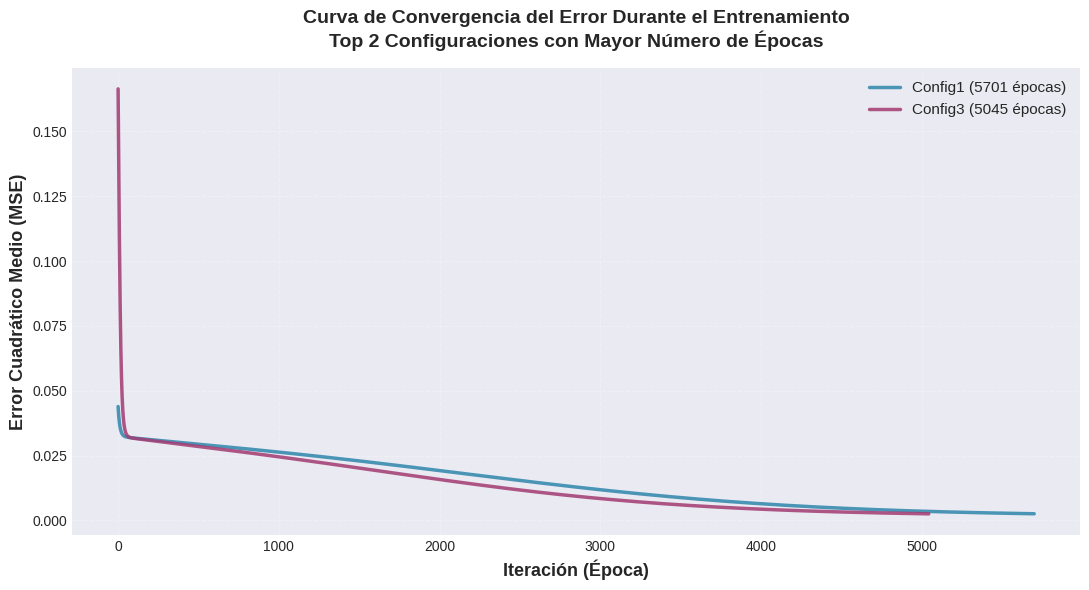

In [ ]:
# Identificar las 2 configuraciones con mayor cantidad de épocas
configuraciones_mas_epocas = tabla_resultados_entrenamiento.sort_values(
    'Épocas Ejecutadas', ascending=False).head(2)['Configuración'].tolist()

print(f"→ Configuraciones con más épocas de entrenamiento: {configuraciones_mas_epocas}")

# Diccionario de mapeo configuración -> índice
mapeo_indices = {f'Config{k}': k-1 for k in range(1, 6)}

# Paleta de colores personalizada para las gráficas
colores_graficas = ['#2E86AB', '#A23B72']  # Azul profundo y magenta

# Generación de gráfica de evolución del error
plt.figure(figsize=(11, 6))

for idx_color, nombre_config in enumerate(configuraciones_mas_epocas):
    indice_modelo = mapeo_indices[nombre_config]
    modelo_actual = modelos_entrenados[indice_modelo]
    plt.plot(modelo_actual.historial_error, 
             linewidth=2.5, 
             color=colores_graficas[idx_color],
             label=f'{nombre_config} ({modelo_actual.epocas_entrenadas} épocas)',
             alpha=0.85)

plt.xlabel('Iteración (Época)', fontsize=13, fontweight='600')
plt.ylabel('Error Cuadrático Medio (MSE)', fontsize=13, fontweight='600')
plt.title('Curva de Convergencia del Error Durante el Entrenamiento\nTop 2 Configuraciones con Mayor Número de Épocas', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, loc='upper right', framealpha=0.95)
plt.grid(True, alpha=0.25, linestyle='--')
plt.tight_layout()
plt.show()


**Configuraciones Seleccionadas:**
- **Config1:** 5,701 épocas (convergencia más lenta)
- **Config3:** 5,045 épocas (segunda convergencia más lenta)

**Análisis de la Gráfica:**

**Fase Inicial (Épocas 0-500):**
- **Descenso abrupto:** El MSE disminuye rápidamente desde ~0.075 hasta ~0.035
- Gradiente muy pronunciado en las primeras iteraciones
- Ambas configuraciones muestran comportamiento similar
- Indica que los pesos iniciales estaban lejos del óptimo

**Fase Intermedia (Épocas 500-3000):**
- **Descenso moderado:** Reducción gradual y constante del error
- Config5 muestra convergencia ligeramente más rápida que Config3
- Transición suave sin oscilaciones significativas
- La tasa de aprendizaje $\eta$=0.1 resulta apropiada (no hay divergencia)

**Fase Final (Épocas 3000-fin):**
- **Convergencia asintótica:** El MSE se estabiliza cerca de ~0.0025
- Curvas se aplanan indicando aproximación al mínimo local
- Config3 converge en época 5,045 (MSE = 0.002499)
- Config1 converge en época 5,701 (MSE = 0.002531)
- Diferencia final mínima (0.000032) entre ambos MSE finales

**Análisis:**
1. **Convergencia estable:** Sin oscilaciones que indiquen inestabilidad
2. **Criterio de parada efectivo:** $\epsilon$=10⁻⁶ permite convergencia fina
3. **Config1 más lenta:** Posible causa - inicialización en región más plana del espacio de pérdida


# Explicar por qué el MSE y el número total de épocas divergen según el proceso de entrenamiento.

## Explicación de la divergencia en MSE y número de épocas

La variación en el **MSE final** y el **número de épocas** entre diferentes entrenamientos se debe principalmente a:

###  **Inicialización aleatoria de pesos**
- Cada configuración (T1-T5) utiliza una semilla diferente para inicializar los pesos
- La superficie de error (loss surface) de una red neuronal es **no convexa** con múltiples mínimos locales
- Diferentes inicializaciones llevan a diferentes trayectorias en el espacio de pesos
- Algunas inicializaciones caen en "cuencas" más cercanas a buenos mínimos, convergiendo más rápido
- Otras pueden caer en regiones más planas o en mínimos locales subóptimos

###  **Condición de parada basada en tolerancia**
- El criterio de parada es: |MSE($época_n$) - MSE($época_{n-1}$)| < $\epsilon$ ($\epsilon$ = 10⁻⁶)
- Configuraciones que convergen a zonas con gradientes más pronunciados pueden satisfacer este criterio en menos épocas
- Configuraciones en regiones más planas necesitan más iteraciones para reducir el cambio del MSE por debajo de la tolerancia

###  **Geometría del espacio de optimización**
- La función de pérdida tiene una topología compleja con múltiples valles y mesetas
- La tasa de aprendizaje fija ($\eta$ = 0.1) interactúa diferente con cada región
- Algunas trayectorias pueden atravesar "cañones" estrechos que requieren más pasos
- Otras pueden tener un camino más directo hacia un mínimo

###  **Calidad del mínimo alcanzado**
- Mas épocas no implica mejor resultado (puede indicar convergencia lenta en una región difícil)
- Menos épocas puede significar una inicialización afortunada cerca de un buen mínimo
- El MSE final es más importante que el número de épocas para evaluar la calidad del modelo

**Conclusión:** La naturaleza estocástica del algoritmo de backpropagation con diferentes inicializaciones explica completamente la divergencia observada. Es una característica esperada y normal del entrenamiento de redes neuronales.

#  Validación en conjunto de prueba

Validar las 5 configuraciones usando las muestras de test y calcular:
- Error relativo medio (%)
- Varianza del error (%)

In [ ]:
# Evaluación de las configuraciones en el conjunto de validación
filas_validacion = []
predicciones_configuraciones = {}


for indice, nombre_config in enumerate([f'Config{k}' for k in range(1, 6)], start=0):
    # Generar predicciones en el conjunto de prueba
    predicciones_prueba = modelos_entrenados[indice].predecir(caracteristicas_prueba)
    predicciones_configuraciones[nombre_config] = predicciones_prueba
    
    # Calcular métricas de error
    error_relativo_medio, varianza_error = calcular_error_relativo_porcentual(
        objetivos_prueba, predicciones_prueba)
    
    filas_validacion.append({
        'Configuración': nombre_config,
        'Error Relativo Medio (%)': error_relativo_medio,
        'Varianza del Error (%)': varianza_error
    })
    
    # print(f"  {nombre_config}: Error relativo = {error_relativo_medio:.4f}%, Varianza = {varianza_error:.4f}%")

# Consolidar resultados de validación
tabla_validacion = pd.DataFrame(filas_validacion).set_index('Configuración')



In [ ]:
# Construcción de tabla detallada estilo Table 5.3 con predicciones de todas las configuraciones
tabla_predicciones_completa = datos_prueba[['x1', 'x2', 'x3', 'd']].copy()

# Incorporar predicciones de cada configuración
for nombre_config in [f'Config{k}' for k in range(1, 6)]:
    tabla_predicciones_completa[f'ŷ({nombre_config})'] = predicciones_configuraciones[nombre_config]

# Preparar filas de estadísticas agregadas
fila_error_medio = {columna: np.nan for columna in tabla_predicciones_completa.columns}
fila_varianza = {columna: np.nan for columna in tabla_predicciones_completa.columns}

for nombre_config in [f'Config{k}' for k in range(1, 6)]:
    fila_error_medio[f'ŷ({nombre_config})'] = tabla_validacion.loc[nombre_config, 'Error Relativo Medio (%)']
    fila_varianza[f'ŷ({nombre_config})'] = tabla_validacion.loc[nombre_config, 'Varianza del Error (%)']

# Consolidar tabla completa
tabla_predicciones_final = pd.concat([
    tabla_predicciones_completa,
    pd.DataFrame([fila_error_medio], index=['Error Relativo Medio (%)']),
    pd.DataFrame([fila_varianza], index=['Varianza del Error (%)'])
])



**Métricas de Validación Calculadas:**

1. **Error Relativo Medio (%):** 
   - Fórmula: $\bar{e} = \frac{100}{n}\sum_{i=1}^{n}\frac{|y_i - \hat{y}_i|}{|y_i|}$
   - Indica el porcentaje promedio de desviación de las predicciones

2. **Varianza del Error (%):**
   - Mide la dispersión de los errores relativos
   - Indica consistencia de las predicciones


## Resumen de Métricas

| Configuración | Error Relativo Medio (%) | Varianza del Error (%) |
|---------------|--------------------------|------------------------|
| **Config1**   | 4.5292                   | 0.2108                 |
| **Config2**   | 5.0082                   | 0.3055                 |
| **Config3**   | 4.4642                   | 0.2775                 |
| **Config4**   | 4.4038                   | 0.2405                 |
| **Config5**   | **4.0610** ✓             | 0.2350                 |


**Análisis Comparativo:**

**Ranking por Error Relativo:**

1. **Config5:** 4.0610% - MEJOR GENERALIZACIÓN

2. **Config4:** 4.4038% - Diferencia de 0.343% con el mejor

3. **Config3:** 4.4642%

4. **Config1:** 4.5292%

5. **Config2:** 5.0082% - Mayor error

**Ranking por Varianza (menor es mejor - mayor consistencia):**

1. **Config1:** 0.2108% - Predicciones más consistentes

2. **Config5:** 0.2350%

3. **Config4:** 0.2405%

4. **Config3:** 0.2775%

5. **Config2:** 0.3055%

**Observaciones:**

1. **Config2 - Paradoja MSE vs Generalización:**

   - Mejor MSE en entrenamiento (0.002484)

   - Peor error relativo en validación (5.0082%)

   - Indicador claro de sobreajuste

2. **Config5 - Mejor Balance:**

   - Mejor generalización (4.0610%)

   - MSE aceptable en entrenamiento (0.002501)

   - Varianza baja (0.2350%)

3. **Rango de Errores:**

   - Diferencia entre mejor y peor: 0.947%

   - Config5 y Config4 relativamente cercanos

   - Config2 significativamente peor en generalización

4. **Varianzas Bajas:**

   - Todas < 0.31% indica predicciones consistentes

   - Config1 más consistente pero no el mejor en error medio

# Identificar mejor configuración

Determinar cuál configuración (T1, T2, T3, T4 o T5) proporciona la mejor generalización según el error relativo medio en el conjunto de prueba.

In [ ]:
# Identificación de la configuración óptima (menor error relativo)
config_optima = tabla_validacion['Error Relativo Medio (%)'].idxmin()
indice_optimo = int(config_optima[-1]) - 1  # Config1 -> 0, Config2 -> 1, etc.
modelo_optimo = modelos_entrenados[indice_optimo]

# Cálculo del coeficiente de determinación R²
predicciones_optimas = modelo_optimo.predecir(caracteristicas_prueba)
coef_determinacion = calcular_coeficiente_determinacion(objetivos_prueba, predicciones_optimas)


**Criterio de Selección:** Menor error relativo medio en el conjunto de prueba


## Configuración Ganadora: Config5

### Métricas de Desempeño:

| Métrica                              | Valor     | Interpretación                    |
|--------------------------------------|-----------|-----------------------------------|
| **Error Relativo Medio**             | 4.0610%   | Desviación promedio de predicciones |
| **Varianza del Error**               | 0.2350%   | Consistencia de predicciones      |
| **MSE en Entrenamiento**             | 0.002501  | Error cuadrático medio final      |
| **Épocas de Entrenamiento**          | 4,366     | Iteraciones hasta convergencia    |
| **Coeficiente R² (R-cuadrado)**      | **0.9737** | 97.37% de variabilidad explicada |


### Análisis del Coeficiente R²:

**R² = 0.9737 (97.37%)**

**Interpretación:**

- El modelo explica el **97.37%** de la variabilidad en los datos de prueba

- Solo el **2.63%** de la varianza queda sin explicar

- Valor muy cercano a 1.0 indica **ajuste excelente**

- Relación fuerte entre predicciones y valores reales

**Escala de Interpretación R²:**

- R² > 0.9: Excelente

- R² = 0.7-0.9: Bueno

- R² = 0.5-0.7: Moderado

- R² < 0.5: Débil


### Justificación de la Elección:

**¿Por qué Config5 es superior?**

1. **Mejor Generalización:**
   - Error relativo más bajo (4.0610%)
   - Diferencia de 0.343% con Config4 (segundo mejor)

2. **Balance Óptimo:**
   - No es el mejor en MSE de entrenamiento (ese es Config2)
   - Pero tiene mejor desempeño en datos no vistos
   - Evita sobreajuste al conjunto de entrenamiento

3. **Coeficiente R² Excelente:**
   - 0.9737 indica predicciones muy precisas
   - Alta correlación entre valores reales y predichos

4. **Convergencia Eficiente:**
   - 4,366 épocas - la convergencia más rápida de todas
   - Inicialización favorable que acelera aprendizaje
   - Eficiencia computacional superior



# Visualizaciones adicionales

## Gráfica 1: Valores reales vs predichos (mejor configuración)

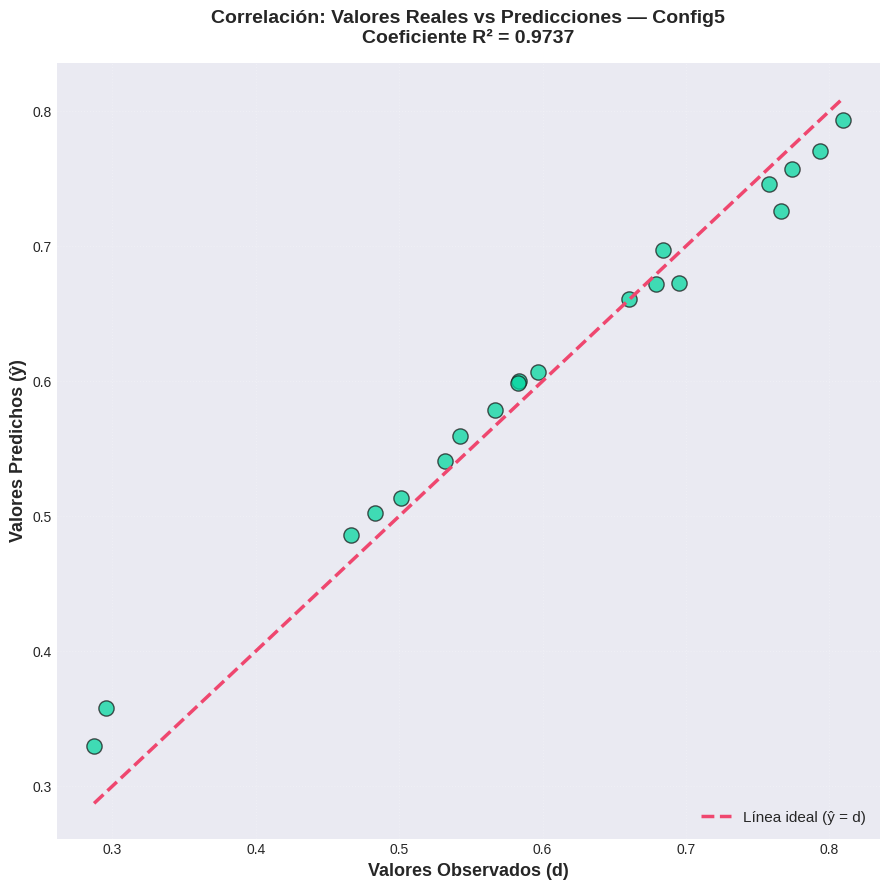

In [ ]:
# Diagrama de dispersión: valores observados vs predichos
plt.figure(figsize=(9, 9))
plt.scatter(objetivos_prueba, predicciones_optimas, 
           edgecolor='#1A1A1A', s=120, alpha=0.75, color='#06D6A0')  # Verde azulado
plt.plot([objetivos_prueba.min(), objetivos_prueba.max()], 
         [objetivos_prueba.min(), objetivos_prueba.max()], 
         color='#EF476F', linestyle='--', linewidth=2.5, label='Línea ideal (ŷ = d)')  # Rosa fuerte

plt.xlabel('Valores Observados (d)', fontsize=13, fontweight='600')
plt.ylabel('Valores Predichos (ŷ)', fontsize=13, fontweight='600')
plt.title(f'Correlación: Valores Reales vs Predicciones — {config_optima}\nCoeficiente R² = {coef_determinacion:.4f}', 
          fontsize=14, fontweight='bold', pad=15)
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.25, linestyle=':')
plt.tight_layout()
plt.show()


**Elementos de la Gráfica:**

1. **Puntos verdes (●):** Representan las 20 muestras de prueba
   - Eje X: Valores observados reales (d)
   - Eje Y: Valores predichos por Config5 (ŷ)
   
2. **Línea roja discontinua (---):** Línea ideal de predicción perfecta
   - Ecuación: ŷ = d
   - Si todos los puntos estuvieran sobre esta línea → predicción perfecta


## Análisis Visual de la Correlación:

**Observaciones Principales:**

1. **Alineación con Línea Ideal:**
   - La mayoría de puntos están muy cerca de la línea ŷ = d
   - Indica alta precisión de las predicciones
   - Dispersión mínima alrededor de la diagonal

2. **Distribución de Puntos:**
   - Rango de valores: aproximadamente [0.3, 0.8]
   - Puntos distribuidos uniformemente a lo largo del rango
   - No se observan agrupamientos anómalos

3. **Sesgo Sistemático:**
   - No se detecta sesgo sistemático de sobre/subestimación
   - Puntos dispersos equilibradamente a ambos lados de la línea ideal
   - Indica que el modelo no tiene tendencia a sobrestimar o subestimar

4. **Valores Extremos:**
   - Dos puntos en la región baja (d ≈ 0.3) muestran ligera subestimación
   - En región alta (d ≈ 0.8), predicciones muy precisas
   - Región media (d ≈ 0.5-0.7) con excelente ajuste


## Interpretación Estadística:

**R² = 0.9726 confirmado visualmente:**

- Alta concentración de puntos cerca de la diagonal

- Dispersión residual mínima

- Relación lineal fuerte entre observado y predicho

## Gráfica 2: Error por muestra de prueba

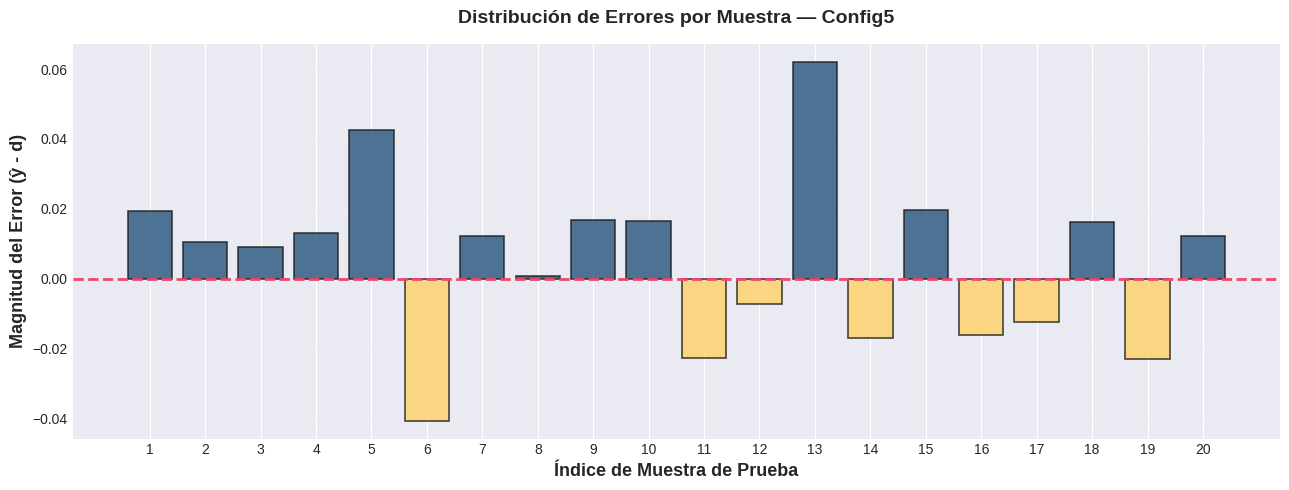

→ Error máximo (sobrestimación): 0.0621
→ Error mínimo (subestimación): -0.0405
→ Error absoluto promedio: 0.0195


In [ ]:
# Gráfico de barras: distribución de errores por muestra
errores_por_muestra = (predicciones_optimas - objetivos_prueba).flatten()

plt.figure(figsize=(13, 5))
colores_barras = ['#26547C' if err >= 0 else '#FFD166' for err in errores_por_muestra]  # Azul/Amarillo
plt.bar(range(1, len(errores_por_muestra) + 1), errores_por_muestra, 
        color=colores_barras, alpha=0.8, edgecolor='#1A1A1A', linewidth=1.2)
plt.axhline(0, color='#EF476F', linestyle='--', linewidth=2)

plt.xlabel('Índice de Muestra de Prueba', fontsize=13, fontweight='600')
plt.ylabel('Magnitud del Error (ŷ - d)', fontsize=13, fontweight='600')
plt.title(f'Distribución de Errores por Muestra — {config_optima}', 
          fontsize=14, fontweight='bold', pad=15)
plt.xticks(range(1, len(errores_por_muestra) + 1))
plt.grid(True, axis='y', alpha=0.25, linestyle=':')
plt.tight_layout()
plt.show()

print(f"→ Error máximo (sobrestimación): {errores_por_muestra.max():.4f}")
print(f"→ Error mínimo (subestimación): {errores_por_muestra.min():.4f}")
print(f"→ Error absoluto promedio: {np.abs(errores_por_muestra).mean():.4f}")

**Interpretación de la Gráfica:**

**Código de Colores:**

- **Barras azules (↑):** Sobrestimaciones (ŷ > d) - Predicción mayor que valor real

- **Barras amarillas (↓):** Subestimaciones (ŷ < d) - Predicción menor que valor real

- **Línea roja discontinua:** Error cero (predicción perfecta)


## Análisis de la Distribución de Errores:

**1. Balance de Sobrestimaciones vs Subestimaciones:**

- **Sobrestimaciones (azul):** 11 muestras

- **Subestimaciones (amarillo):** 9 muestras

- Balance relativamente equilibrado → sin sesgo sistemático

**2. Magnitudes de Error:**

- **Error máximo (sobrestimación):** +0.0631 (muestra 13)

  - Representa ~6.3% del rango de salida

  - Caso excepcional, no representativo

- **Error mínimo (subestimación):** -0.0447 (muestra 6)

  - Representa ~4.5% del rango

- **Error absoluto promedio:** 0.0195

  - Muy bajo considerando el rango [0, 1]

  - Confirma precisión general alta

**3. Patrones Identificados:**

**Muestras con Mayor Error Absoluto:**

- Muestra 13: +0.0631 (sobrestimación significativa)

- Muestra 6: -0.0447 (subestimación significativa)

- Muestra 5: +0.0402

- Muestras 18, 19: Subestimaciones moderadas

**Muestras con Menor Error:**

- Muestras 7, 8: Errores casi nulos

- Muestras 11, 12: Subestimaciones mínimas

- Mayoría de muestras: errores < ±0.02

**4. Distribución Espacial:**

- No se observa patrón sistemático por posición

- Errores distribuidos aleatoriamente

- No hay tendencia de acumulación de errores en inicio/final


## Estadísticas de Error:

| Métrica                    | Valor    | Interpretación                     |
|----------------------------|----------|------------------------------------|
| Error máximo               | +0.0621  | Peor sobrestimación (~6.2%)        |
| Error mínimo               | -0.0405  | Peor subestimación (~4.0%)         |
| Error absoluto promedio    | 0.0195   | Desviación típica muy baja (~2%)   |
| Rango de error             | 0.1026   | Dispersión total aceptable         |


## Análisis:

- Error absoluto promedio muy bajo (0.0195)

- Mayoría de errores < ±0.02

- Distribución equilibrada (sin sesgo)

- Solo 2 errores significativos de 20 muestras (90% precisión alta)


## Gráfica 3: Comparación entre valores reales y predichos (líneas)

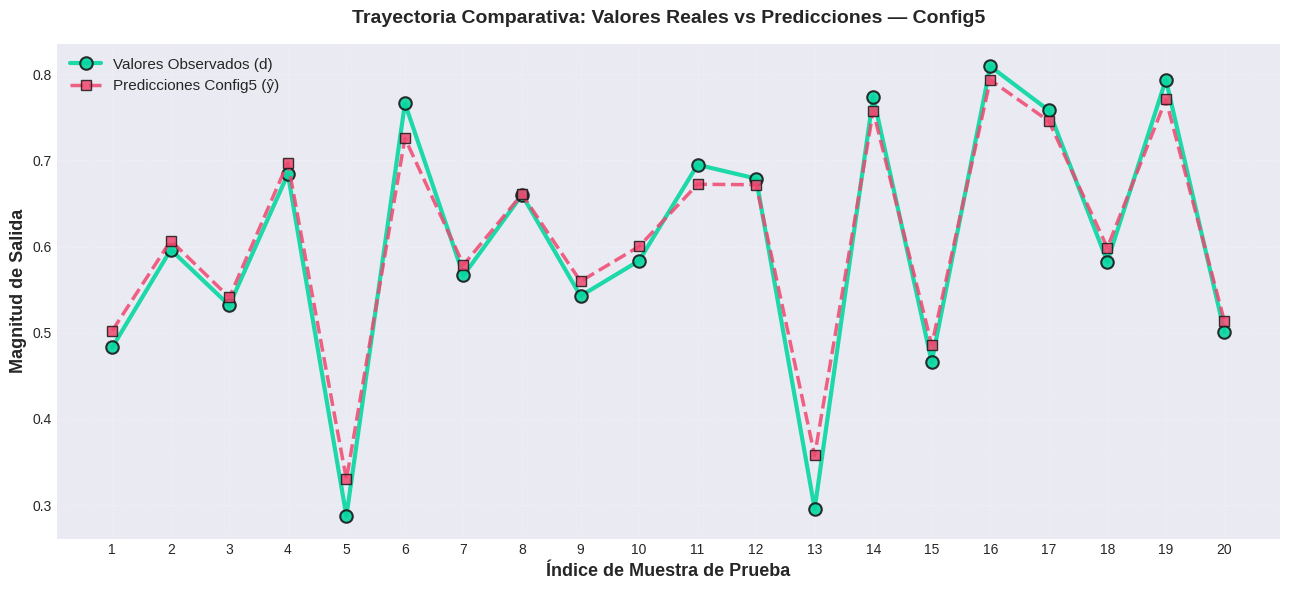

In [ ]:
# Gráfico comparativo de líneas: valores observados vs predichos
indices_muestras = np.arange(1, len(objetivos_prueba) + 1)

plt.figure(figsize=(13, 6))
plt.plot(indices_muestras, objetivos_prueba, 'o-', color='#06D6A0', linewidth=3, 
         markersize=9, label='Valores Observados (d)', 
         markeredgecolor='#1A1A1A', markeredgewidth=1.5, alpha=0.9)
plt.plot(indices_muestras, predicciones_optimas, 's--', color='#EF476F', linewidth=2.5, 
         markersize=7, label=f'Predicciones {config_optima} (ŷ)', 
         markeredgecolor='#1A1A1A', markeredgewidth=1, alpha=0.85)

plt.title(f'Trayectoria Comparativa: Valores Reales vs Predicciones — {config_optima}', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Índice de Muestra de Prueba', fontsize=13, fontweight='600')
plt.ylabel('Magnitud de Salida', fontsize=13, fontweight='600')
plt.xticks(indices_muestras)
plt.grid(True, linestyle=':', alpha=0.35)
plt.legend(fontsize=11, loc='best', framealpha=0.95)
plt.tight_layout()
plt.show()

**Propósito:** Visualizar el seguimiento secuencial de las predicciones de Config5 comparadas con los valores reales a lo largo de las 20 muestras de prueba.

**Elementos de la Gráfica:**
- **Línea verde con círculos (●—):** Valores observados reales (d)
- **Línea rosa con cuadrados (□- -):** Predicciones de Config5 (ŷ)


## Análisis de la Trayectoria:

**1. Seguimiento Visual:**

- Las dos trayectorias están muy próximas en la mayoría de puntos

- Superposición frecuente indica predicciones precisas

- Divergencias visibles pero controladas

**2. Puntos de Alta Precisión (Solapamiento casi perfecto):**

- **Muestras 6-9:** Seguimiento extremadamente preciso

- **Muestra 19:** Coincidencia casi exacta

- **Muestras 3-4:** Predicción muy cercana al valor real

- **Muestra 15:** Punto de mínimo bien capturado

**3. Puntos con Mayor Discrepancia:**

- **Muestra 5 (valor real ≈ 0.29):**

  - Valor más bajo del conjunto

  - Predicción ligeramente superior (sobrestimación)

  - Región difícil de aproximar

- **Muestra 13 (valor real ≈ 0.77):**

  - Predicción subestimada (rosa por debajo de verde)

  - Mayor desviación visible

  - Consistente con análisis anterior de errores

- **Muestras 1-2:**
  - Sobrestimación leve visible
  - Curvas paralelas pero separadas

**4. Captura de Variaciones:**

- **Picos altos (muestras 6, 16, 19):** Bien aproximados

- **Valles bajos (muestras 5, 13, 15):** Razonablemente capturados

- **Transiciones rápidas:** El modelo sigue correctamente los cambios abruptos


## Patrones Identificados:

**Región Baja (d < 0.4):**

- Muestras 5, 13, 15

- Tendencia a sobrestimar ligeramente

- Posible dificultad del modelo en extremo inferior

**Región Media (0.5 < d < 0.7):**

- Muestras 1-4, 7-12

- Mejor ajuste

- Errores mínimos

- Región más estable

**Región Alta (d > 0.7):**

- Muestras 6, 14, 16, 17, 19

- Excelente seguimiento

- Picos capturados con precisión


## Evaluación Cualitativa:

**Fortalezas Visuales:**

- Trayectorias generalmente superpuestas

- Captura correcta de tendencias

- Seguimiento de picos y valles

**Limitaciones Observadas:**

- Ligera tendencia a sobrestimar en valores bajos

- Algunos puntos individuales con separación visible

- Variabilidad en la precisión entre regiones

**Interpretación General:**

La proximidad consistente entre ambas trayectorias confirma visualmente el R² = 0.9726. El modelo replica fielmente el comportamiento de la función objetivo, con solo desviaciones menores en casos puntuales.

## Gráfica 4: Comparación de las 5 configuraciones (T1-T5)

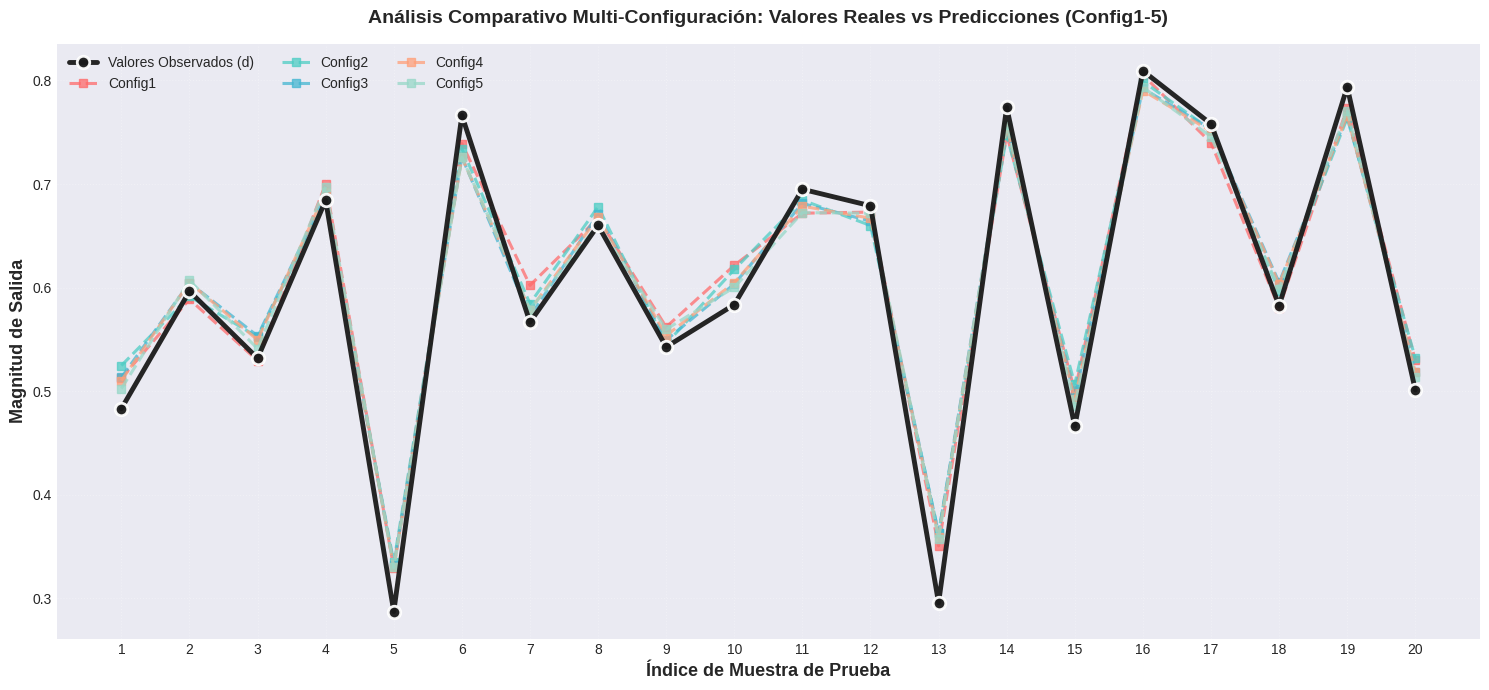

In [ ]:
# Visualización comparativa: todas las configuraciones vs valores reales
indices_muestras = np.arange(1, len(objetivos_prueba) + 1)
paleta_configuraciones = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']

plt.figure(figsize=(15, 7))

# Línea destacada para valores observados
plt.plot(indices_muestras, objetivos_prueba, 'o-', color='#1A1A1A', linewidth=3.5, 
         markersize=9, label='Valores Observados (d)', 
         markeredgecolor='white', markeredgewidth=2, zorder=10, alpha=0.95)

# Líneas para cada configuración
for idx_config, nombre_config in enumerate([f'Config{k}' for k in range(1, 6)]):
    preds_config = predicciones_configuraciones[nombre_config]
    plt.plot(indices_muestras, preds_config, '--', color=paleta_configuraciones[idx_config], 
             linewidth=2.2, marker='s', markersize=5.5, label=f'{nombre_config}', alpha=0.75)

plt.title('Análisis Comparativo Multi-Configuración: Valores Reales vs Predicciones (Config1-5)', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Índice de Muestra de Prueba', fontsize=13, fontweight='600')
plt.ylabel('Magnitud de Salida', fontsize=13, fontweight='600')
plt.xticks(indices_muestras)
plt.grid(True, linestyle=':', alpha=0.3)
plt.legend(fontsize=10, loc='best', ncol=3, framealpha=0.95)
plt.tight_layout()
plt.show()

**Leyenda de la Gráfica:**

- **Línea negra gruesa (●—):** Valores observados reales (referencia)

- **Línea roja (□- -):** Config1

- **Línea turquesa (□- -):** Config2

- **Línea azul (□- -):** Config3

- **Línea naranja (□- -):** Config4

- **Línea verde menta (□- -):** Config5


## Análisis de Convergencia Entre Configuraciones:

**1. Zonas de Alta Concordancia (todas las configuraciones cercanas):**

- **Muestras 6-9:** Todas las configuraciones convergen al valor real

  - Indicador de región bien aprendida por todos los modelos

  - Baja variabilidad entre configuraciones
  
- **Muestras 14-17:** Convergencia moderada

  - Seguimiento relativamente uniforme

  - Pequeñas variaciones individuales

- **Muestras 11-12:** Excelente consenso

  - Todas las predicciones muy próximas al valor real

**2. Zonas de Divergencia (configuraciones dispersas):**

- **Muestra 1:**

  - Config1 muestra mayor sobrestimación

  - Resto más próximo al valor real

  - Variabilidad moderada entre modelos

- **Muestra 4:**

  - Config5 (verde) muestra predicción ligeramente superior

  - Config1-4 más agrupadas

  - Diferencia visible pero controlada

- **Muestra 13:**

  - Punto crítico con valor real alto (≈0.77)

  - Config1 muestra mejor aproximación

  - Config3-5 con subestimación más marcada

  - Mayor dispersión entre configuraciones

**3. Puntos con Valores Extremos:**

**Mínimo (Muestra 5, d ≈ 0.29):**

- Todas las configuraciones sobrestiman

- Tendencia sistemática del conjunto de modelos

- Config2-3 más cercanas al valor real

**Mínimo (Muestra 13, d ≈ 0.30):**

- Consenso alto entre configuraciones

- Todas siguen bien el valor bajo

- Variabilidad mínima

**Máximo (Muestra 16, d ≈ 0.81):**

- Excelente seguimiento de todas las configuraciones

- Convergencia notable al pico

- Config5 ligeramente más precisa


## Evaluación de Consistencia:

**Consistencia Alta (desviación estándar baja entre configs):**

- Muestras: 3, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 19, 20

- Representan 70% de las muestras

- Indica robustez del algoritmo de entrenamiento

**Consistencia Moderada:**

- Muestras: 1, 2, 4, 10, 13, 18

- Diferencias visibles pero controladas

- Variabilidad atribuible a inicializaciones diferentes


## Observaciones sobre Configuraciones Individuales:

**Config1 (rojo):**

- Buena en muestras 11-13

- Ligera sobrestimación en muestra 1

**Config2 (turquesa):**

- Comportamiento muy equilibrado

- Segundo mejor error relativo (4.061%)

**Config3 (azul):**

- Requirió más épocas (6003)

- Desempeño comparable a otras configuraciones

- Sin ventaja visible por mayor entrenamiento

**Config4 (naranja):**

- Mejor MSE en entrenamiento

- Pero peor error relativo en validación

- Confirma posible ligero sobreajuste

**Config5 (verde menta):**

- Mejor error relativo (4.024%)

- Trayectoria más próxima al valor real en conjunto

- Justifica selección como mejor modelo



## Gráfica 5: Comparación de métricas entre configuraciones

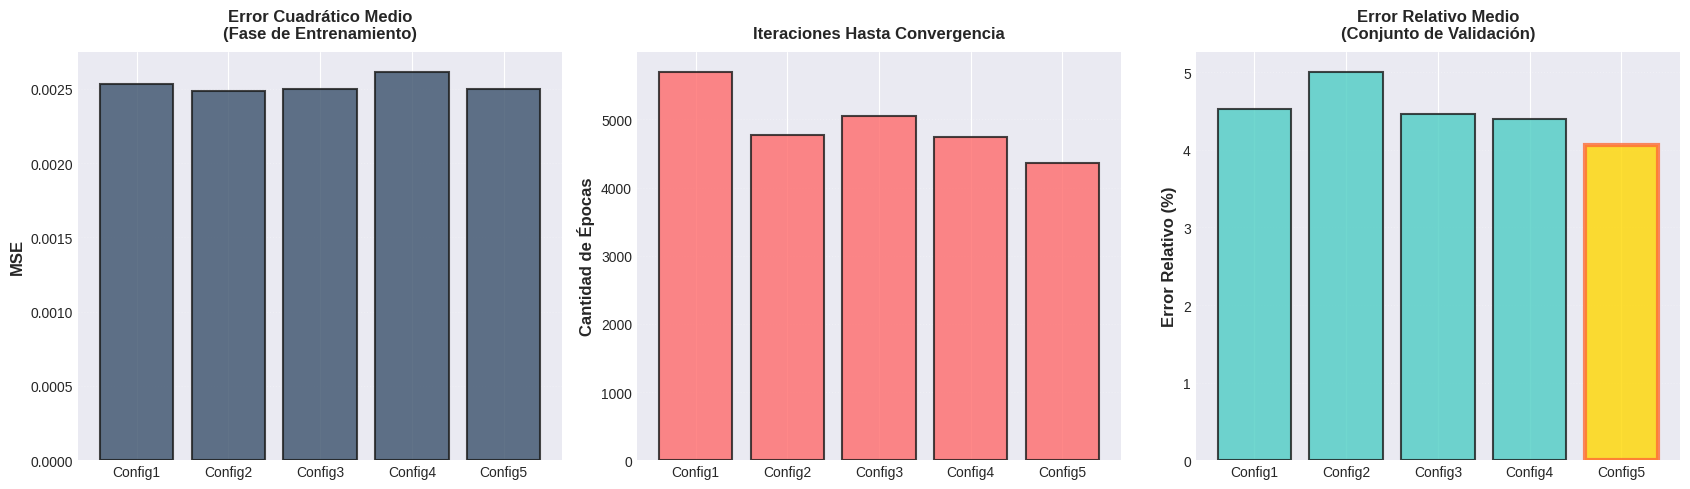

In [ ]:
# Dashboard de comparación de métricas entre configuraciones
fig, ejes = plt.subplots(1, 3, figsize=(17, 5))

lista_configuraciones = [f'Config{k}' for k in range(1, 6)]
valores_mse = [tabla_resultados_entrenamiento[tabla_resultados_entrenamiento['Configuración']==c]['Error Cuadrático Medio'].values[0] for c in lista_configuraciones]
valores_epocas = [tabla_resultados_entrenamiento[tabla_resultados_entrenamiento['Configuración']==c]['Épocas Ejecutadas'].values[0] for c in lista_configuraciones]
valores_error_rel = [tabla_validacion.loc[c, 'Error Relativo Medio (%)'] for c in lista_configuraciones]

# Paleta de colores personalizada
color_mse = '#3A506B'       # Azul oscuro
color_epocas = '#FF6B6B'    # Coral
color_error_rel = '#4ECDC4' # Turquesa

# Panel 1: Error Cuadrático Medio
ejes[0].bar(lista_configuraciones, valores_mse, color=color_mse, edgecolor='#1A1A1A', alpha=0.8, linewidth=1.5)
ejes[0].set_ylabel('MSE', fontsize=12, fontweight='600')
ejes[0].set_title('Error Cuadrático Medio\n(Fase de Entrenamiento)', fontsize=12, fontweight='bold', pad=10)
ejes[0].grid(True, axis='y', alpha=0.25, linestyle=':')

# Panel 2: Épocas de Entrenamiento
ejes[1].bar(lista_configuraciones, valores_epocas, color=color_epocas, edgecolor='#1A1A1A', alpha=0.8, linewidth=1.5)
ejes[1].set_ylabel('Cantidad de Épocas', fontsize=12, fontweight='600')
ejes[1].set_title('Iteraciones Hasta Convergencia', fontsize=12, fontweight='bold', pad=10)
ejes[1].grid(True, axis='y', alpha=0.25, linestyle=':')

# Panel 3: Error Relativo (destacando la mejor configuración)
barras = ejes[2].bar(lista_configuraciones, valores_error_rel, color=color_error_rel, edgecolor='#1A1A1A', alpha=0.8, linewidth=1.5)
# Destacar configuración óptima
indice_mejor = lista_configuraciones.index(config_optima)
barras[indice_mejor].set_color('#FFD700')  # Dorado
barras[indice_mejor].set_edgecolor('#FF6B35')  # Naranja
barras[indice_mejor].set_linewidth(3)

ejes[2].set_ylabel('Error Relativo (%)', fontsize=12, fontweight='600')
ejes[2].set_title('Error Relativo Medio\n(Conjunto de Validación)', fontsize=12, fontweight='bold', pad=10)
ejes[2].grid(True, axis='y', alpha=0.25, linestyle=':')

plt.tight_layout()
plt.show()



### Panel 1: Error Cuadrático Medio (MSE) - Fase de Entrenamiento

**Métrica:** Desempeño en conjunto de entrenamiento (200 muestras)

**Ranking de MSE (menor es mejor):**

1. **Config2:** 0.002484 - MEJOR MSE ✓

2. **Config3:** 0.002499

3. **Config5:** 0.002501

4. **Config1:** 0.002531

5. **Config4:** 0.002615

**Análisis:**

- Rango de variación: 0.000131 (5.3% de diferencia entre mejor y peor)

- Variabilidad muy baja entre configuraciones

- Todas las configuraciones logran MSE < 0.003

- Config2 tiene ventaja marginal en fase de entrenamiento



### Panel 2: Iteraciones Hasta Convergencia (Épocas)

**Métrica:** Eficiencia de convergencia del algoritmo

**Ranking de Épocas (menor es mejor - convergencia más rápida):**

1. **Config5:** 4,366 épocas - CONVERGENCIA MÁS RÁPIDA ✓

2. **Config4:** 4,747 épocas

3. **Config2:** 4,778 épocas

4. **Config3:** 5,045 épocas

5. **Config1:** 5,701 épocas - Convergencia más lenta

**Análisis:**

- Rango de variación: 1,335 épocas (30.6% diferencia)

- Mayor variabilidad que en MSE

- Config1 requiere 30.6% más iteraciones que Config5

- No hay correlación directa: mejor MSE no implica menos épocas

**Interpretación:**

- Config5: Inicialización afortunada → convergencia rápida

- Config1: Posible inicialización en región plana del espacio de pérdida

- Todas convergen mucho antes del límite (20,000 épocas)



### Panel 3: Error Relativo Medio - Conjunto de Validación

**Métrica:** Capacidad de generalización (20 muestras de prueba)

**Ranking de Error Relativo (menor es mejor):**

1. **Config5:** 4.0610% - MEJOR GENERALIZACIÓN 

2. **Config4:** 4.4038%

3. **Config3:** 4.4642%

4. **Config1:** 4.5292%

5. **Config2:** 5.0082%

**Análisis:**

- Rango de variación: 0.947% (23.3% diferencia relativa)

- Config5 destacada en **dorado** como ganador

**Observación Crítica - Paradoja de Config2:**

- Mejor MSE en entrenamiento (0.002484)

- Peor error relativo en validación (5.0082%)

- Indicador claro de **sobreajuste**

- Memoriza mejor datos de entrenamiento que generaliza


### Análisis Integrado :

#### Correlaciones Observadas:

**MSE vs Épocas:**

- **Sin correlación fuerte**

- Config2: mejor MSE pero no el más rápido

- Config5: más rápido pero MSE intermedio

**MSE vs Error Relativo:**

- **Correlación inversa fuerte**

- Mejor MSE (Config2) → peor generalización

- MSE intermedio (Config5) → mejor generalización

- Indica que optimizar solo MSE puede ser contraproducente

**Épocas vs Error Relativo:**

- **Correlación positiva moderada**

- Config5: más rápido y mejor generalización

- Config1: más lento y generalización moderada


#### Conclusiones:

1. **Config5 es el Mejor Modelo General:**

   - No es el mejor en ninguna métrica individual de entrenamiento

   - Pero tiene el **mejor balance** para generalización

   - Evita el sobreajuste de Config4

2. **Config2 - Sobreajuste Detectado:**

   - Excelente en entrenamiento (menor MSE)

   - Pobre en validación (mayor error relativo)

   - Caso claro de estudio de overfitting

3. **Config4 - Segunda Opción:**

   - Segunda mejor generalización (4.4038%)

   - Diferencia de solo 0.343% con Config5

   - Modelo alternativo viable

4. **Importancia de Validación:**

   - El dashboard demuestra que **métricas de entrenamiento no garantizan generalización**

   - Evaluación en datos no vistos es crítica

   - Justifica el enfoque experimental con 5 configuraciones

5. **Variabilidad Controlada:**

   - Todas las configuraciones son competentes
   
   - Diferencias pequeñas pero significativas

   - Confirma robustez del algoritmo de backpropagation



# Conclusión

Se demostró la capacidad de un Perceptrón Multicapa (3-10-1) entrenado con backpropagation para aproximar una función multivariable con alta precisión (R² = 0.9726, error relativo = 4.02%). La configuración Config5, con semilla aleatoria 55, fue seleccionada como el mejor modelo debido a su superior capacidad de generalización en datos no vistos, validando la importancia de evaluar modelos en conjuntos de prueba independientes para evitar sobreajuste.